In [1]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, GRO, XTC
from MDAnalysis.analysis import rms

import warnings
# suppress some MDAnalysis warnings about PSF files
#warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

import subprocess
import glob
import pandas as pd
import os


General settings

Reading all results files

In [2]:
def generate_plots_mdanalysis(name,run,resultsdir,dataframedir):

    ##### PARM file

    parmfile=resultsdir+name+'.parm7'
    print('parameter file:',parmfile)

    ##### TRAJECTORY FILES

    trajfiles = sorted(glob.glob(resultsdir+run+name+'_*.nc'))
    print('trajectory files:',trajfiles)
      
    # some information
    u = mda.Universe(parmfile,trajfiles)
    protein = u.select_atoms("protein")

    print('Trajectory of run {0} contains {1} steps'.format(run,len(u.trajectory)))

    time = []
    rgyr = []
    for ts in u.trajectory:
        time.append(u.trajectory.time)
        rgyr.append(protein.radius_of_gyration())

    rgyr_df = pd.DataFrame(list(zip(time, rgyr)),
                columns =['Time (ps)', 'Radius of gyration (A)'],
                index=None)
    rgyr_df.to_csv(dataframedir+name+'RG.csv',index=False)

    x_name = rgyr_df.columns[0]
    y_name = rgyr_df.columns[1]
    x=rgyr_df[x_name]
    y=rgyr_df[y_name]

    ax = rgyr_df.plot(title=name+': Radius of gyration',x=x_name, y=y_name,kind='line')
    ax.set_ylabel(r'R$_g$ ($\AA$)')
    plt.savefig('../text/figures/'+name+'RG.png')

    u.trajectory[0] # set to first frame
    rmsd_analysis = rms.RMSD(u, select='backbone')
    rmsd_analysis.run()
    #rmsd_analysis.results.rmsd.shape
    #print(rmsd_analysis.rmsd.shape)

    rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd,
                        columns=['Frame', 'Time (ps)', 'Backbone'])
    rmsd_df = rmsd_df[['Time (ps)', 'Backbone']]
    rmsd_df.to_csv(dataframedir+name+'RMSD.csv',index=False)
    #rmsd_df.head()


    ax = rmsd_df.plot(title=name+': RMSD',x='Time (ps)', y=['Backbone'],kind='line')
    ax.set_ylabel(r'RMSD ($\AA$)')
    plt.savefig('../text/figures/'+name+'RMSD.png')



In [3]:
def generate_plots_mdout(name,run,resultsdir,dataframedir):


    ##### MDOUT files

    mdoutfiles = sorted(glob.glob(resultsdir+run+name+'_*.mdout'))
    print(mdoutfiles)

    ##### generate summary files from all mdout files
    pipe = subprocess.run(["process_mdout.perl"]+mdoutfiles,
                        check=True,
                        text=True,
                        capture_output=True)
    # assign dataset names
    data = {'DENSITY':r'$\rho$',
            'EKCMT':r'E_k CMT / kcal mol$^-1$',
            'EKTOT':r'E_k / kcal mol$-1$',
            'EPTOT':r'E_p / kcal mol$-1$',
            'ESCF':r'ESCF',
            'ETOT':r'E_tot / kcal mol$-1$',
            'PRES':r'PRESS',
            'TEMP':r'T / K',
            'TSOLUTE':r'T / K',
            'TSOLVENT':r'T / K',
            'VOLUME':r'V / $\AA^3$'}
 
    # create empty lists
    dataframes_list = []
    Ylabel_list = []
    Title_list = []

    # append datasets into the list
    for key, value in data.items():
        colnames=['Time (ps)',key]
        #print(colnames)
        temp_df = pd.read_csv("summary."+key,names=colnames,sep='\s+',index_col=None)
        if not temp_df.isnull().values.any():
            dataframes_list.append(temp_df)
            temp_df.to_csv(dataframedir+name+key+'.csv',index=False)
            Ylabel_list.append(value)
            Title_list.append(key)

    for i in range(len(dataframes_list)):
        dataframes_list[i].plot(x=colnames[0],y=Title_list[i])
        plt.ylabel(Ylabel_list[i])
        plt.title(name+': '+Title_list[i])
        plt.savefig('../text/figures/'+name+Title_list[i]+'.png')



parameter file: /home/jordivilla/Backup/lavandula/dao_noNAG.parm7
trajectory files: ['/home/jordivilla/Backup/lavandula/mddao_noNAG_1.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_2.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_3.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_4.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_5.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_6.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_7.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_8.nc', '/home/jordivilla/Backup/lavandula/mddao_noNAG_9.nc']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Trajectory of run md contains 804 steps
['/home/jordivilla/Backup/lavandula/mddao_noNAG_1.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_2.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_3.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_4.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_5.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_6.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_7.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_8.mdout', '/home/jordivilla/Backup/lavandula/mddao_noNAG_9.mdout']
parameter file: /home/jordivilla/Backup/lapalma/dao_noNAG_TRE5.parm7
trajectory files: ['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_1.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_2.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_3.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_4.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_5.nc']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Trajectory of run md contains 827 steps
['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_1.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_2.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_3.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_4.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE5_5.mdout']
parameter file: /home/jordivilla/Backup/lapalma/dao_noNAG_TRE25.parm7
trajectory files: ['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_1.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_2.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_3.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_4.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_5.nc']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Trajectory of run md contains 764 steps
['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_1.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_2.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_3.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_4.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE25_5.mdout']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


parameter file: /home/jordivilla/Backup/lapalma/dao_noNAG_TRE100.parm7
trajectory files: ['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_1.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_2.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_3.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_4.nc']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Trajectory of run md contains 481 steps
['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_1.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_2.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_3.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE100_4.mdout']
parameter file: /home/jordivilla/Backup/lapalma/dao_noNAG_TRE250.parm7
trajectory files: ['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_1.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_2.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_3.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_4.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_5.nc']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Trajectory of run md contains 538 steps
['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_1.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_2.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_3.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_4.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE250_5.mdout']
parameter file: /home/jordivilla/Backup/lapalma/dao_noNAG_TRE500.parm7
trajectory files: ['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_1.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_2.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_3.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_4.nc', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_5.nc']


/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Trajectory of run md contains 591 steps
['/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_1.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_2.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_3.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_4.mdout', '/home/jordivilla/Backup/lapalma/mddao_noNAG_TRE500_5.mdout']


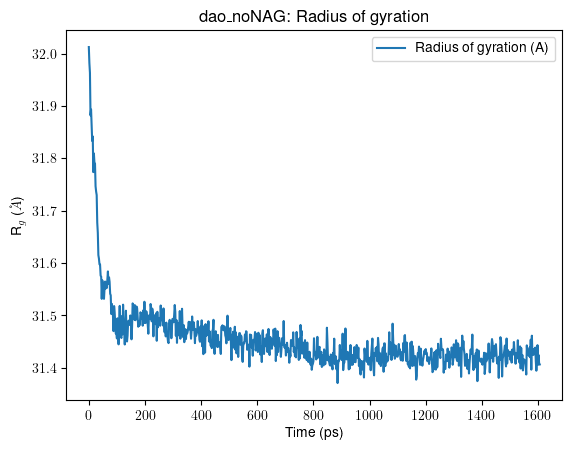

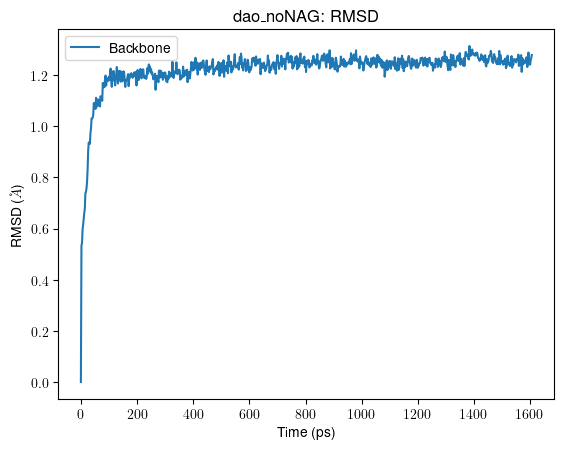

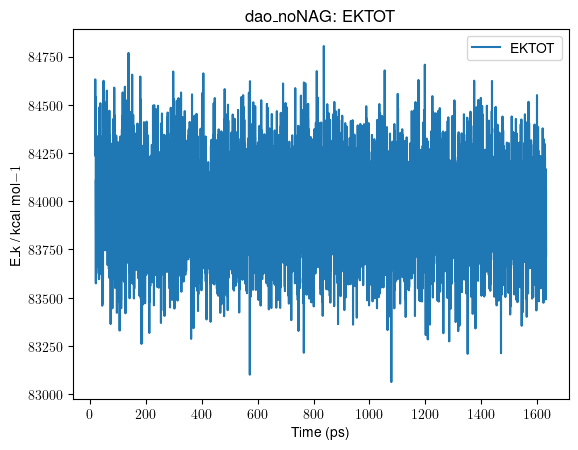

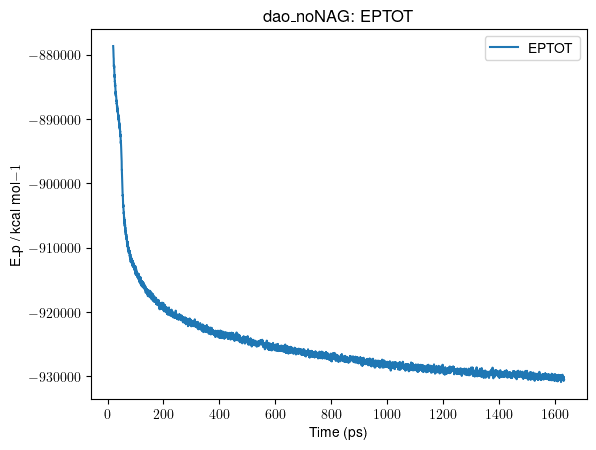

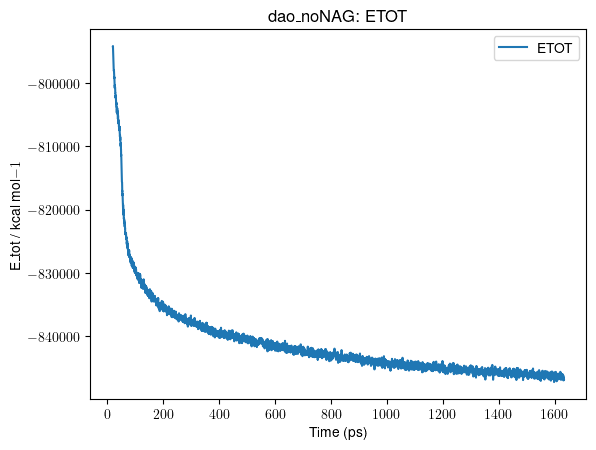

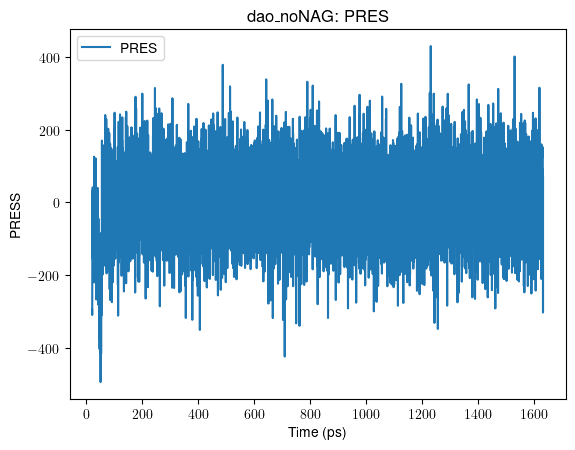

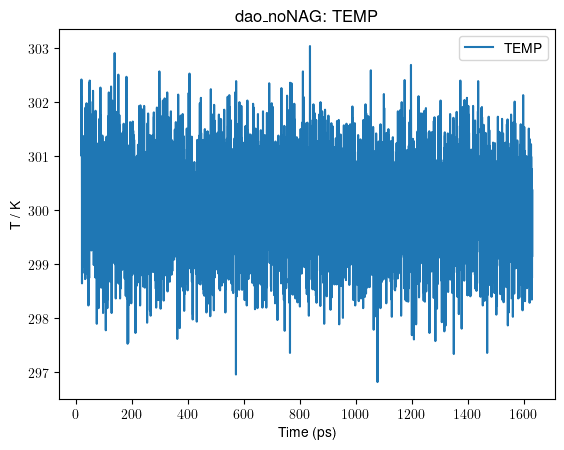

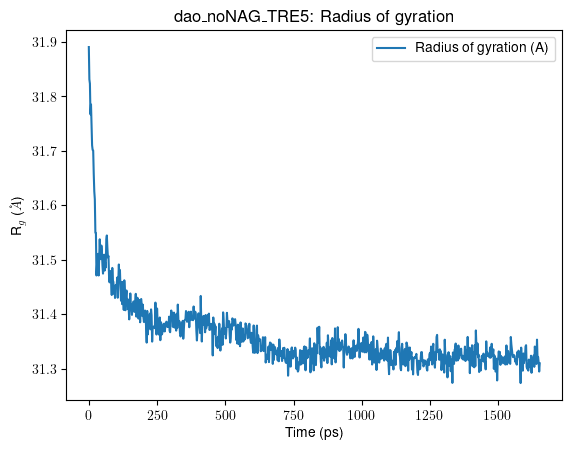

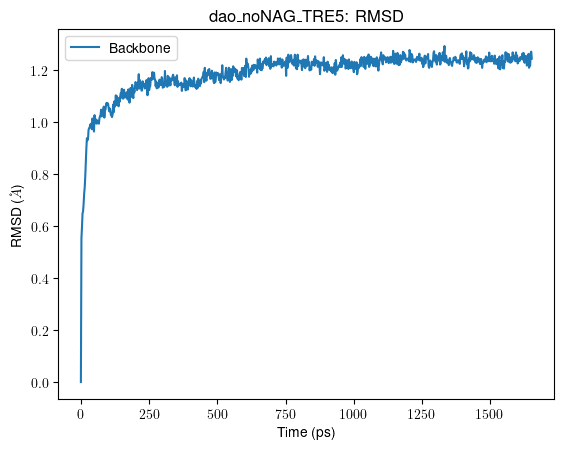

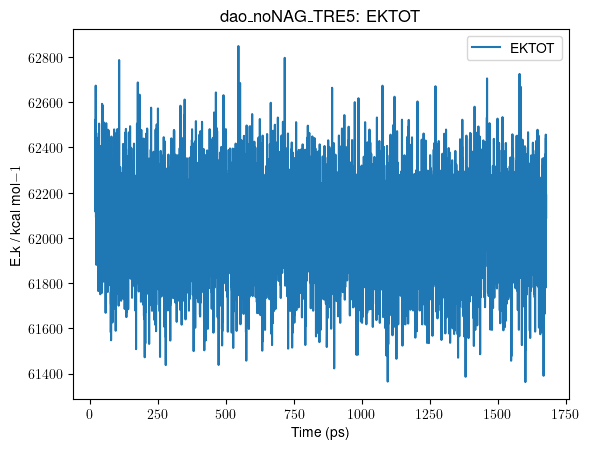

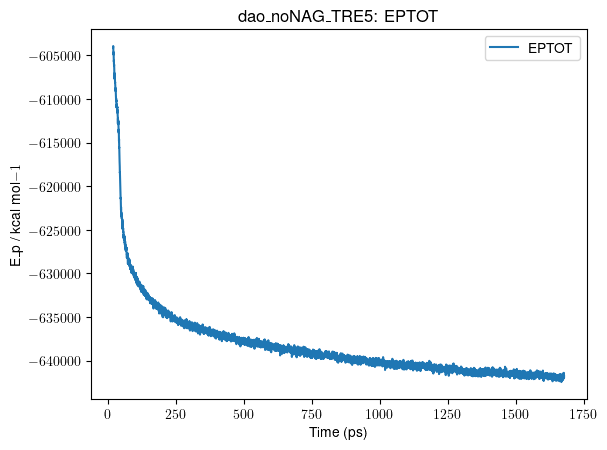

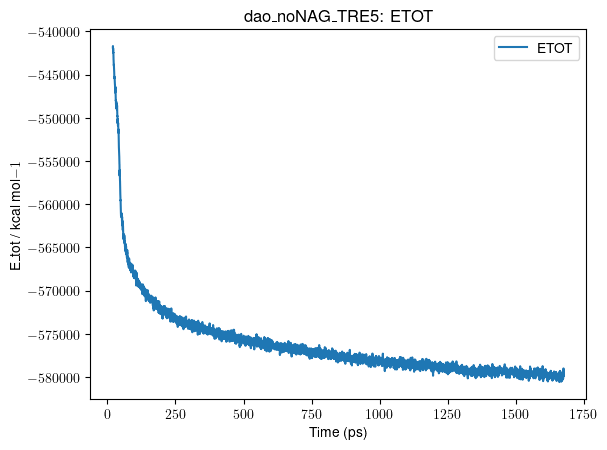

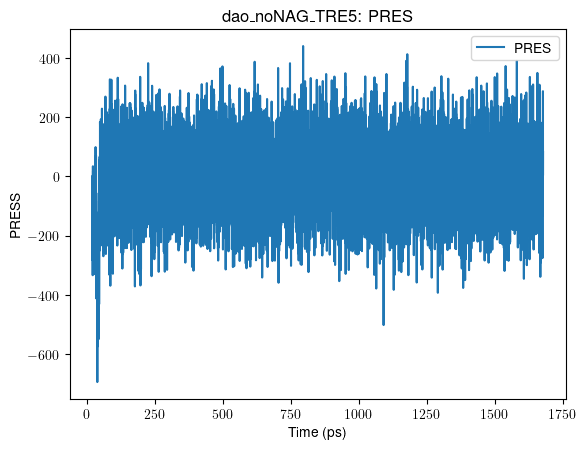

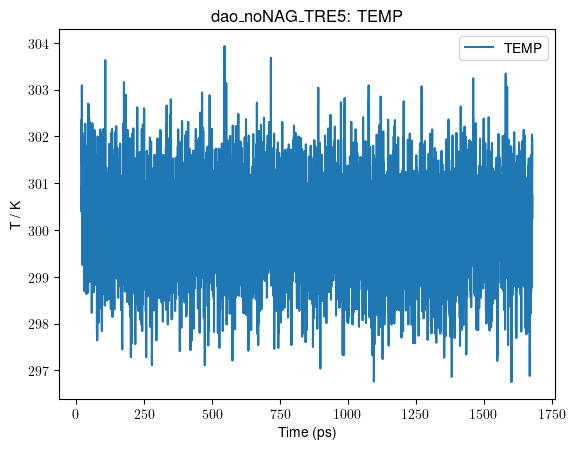

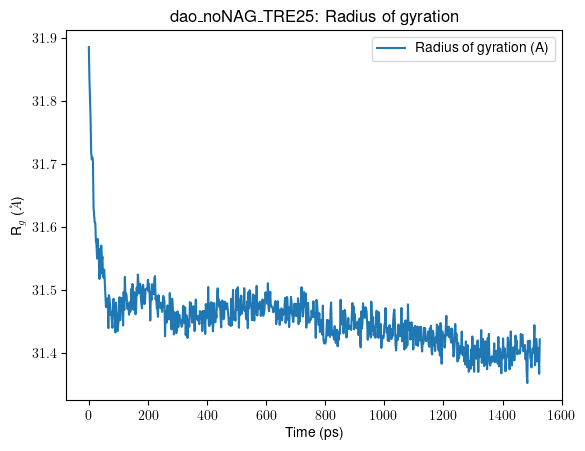

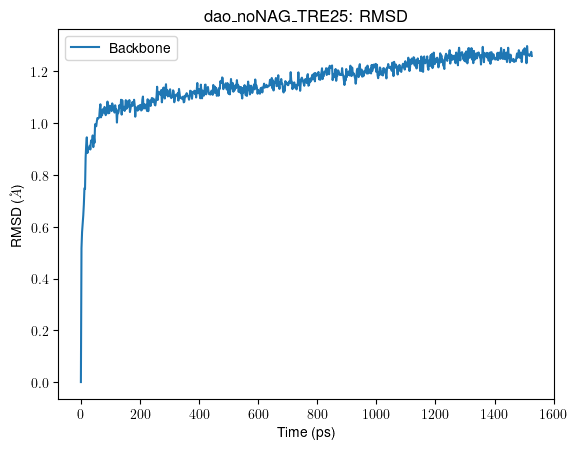

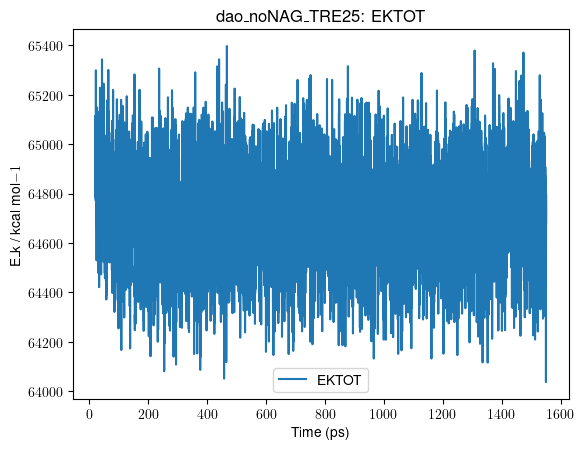

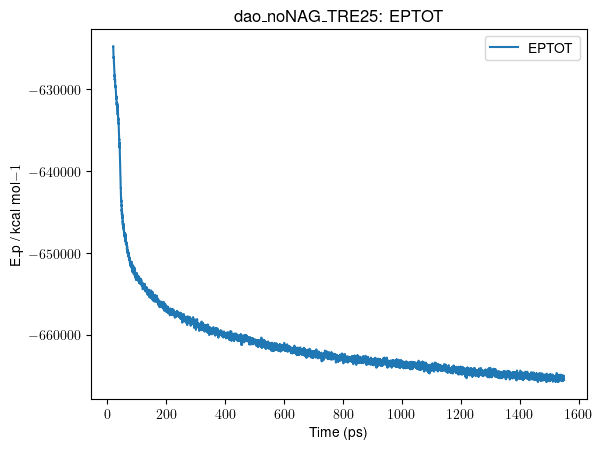

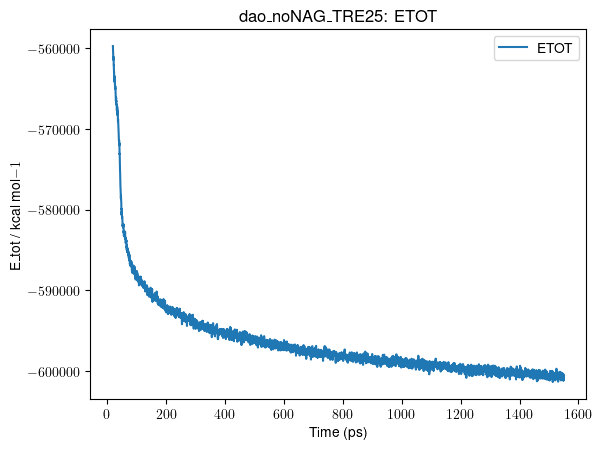

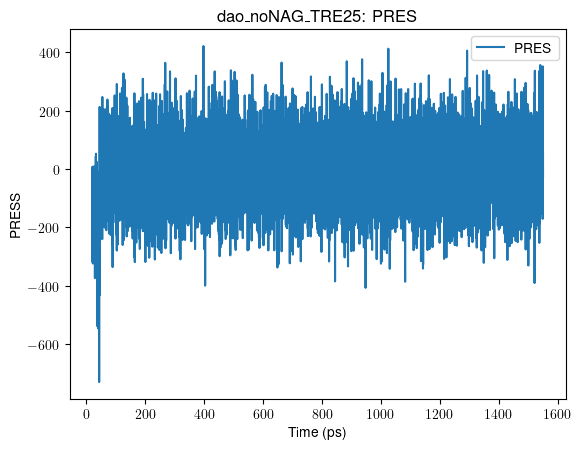

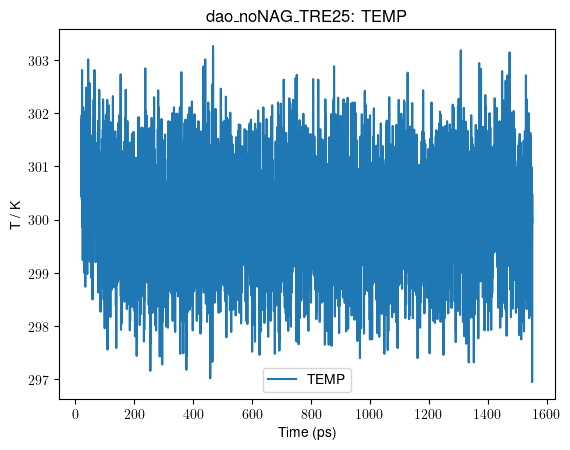

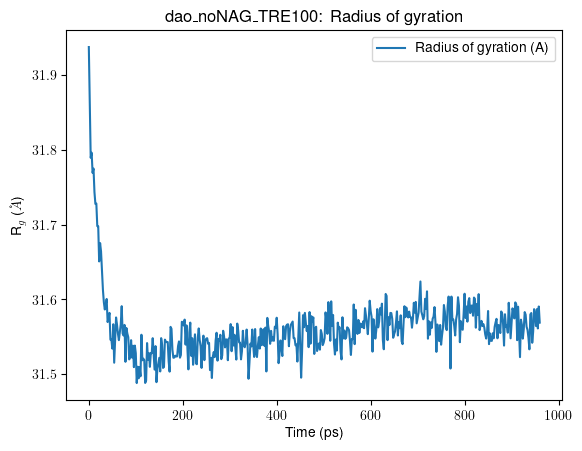

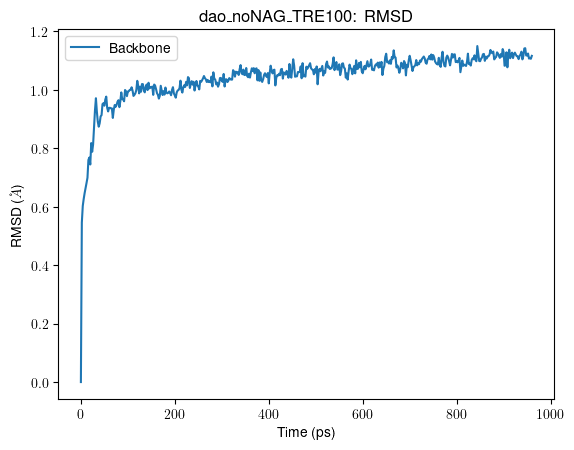

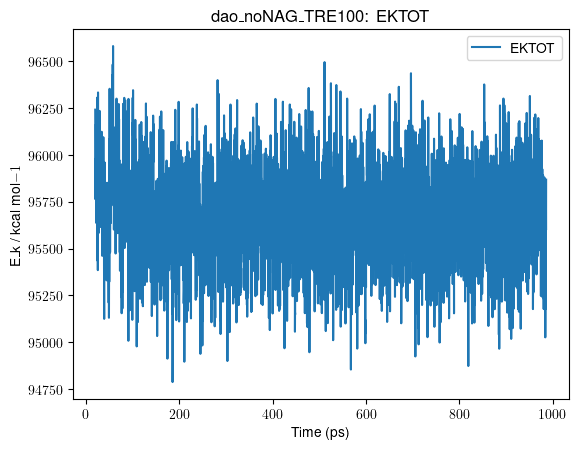

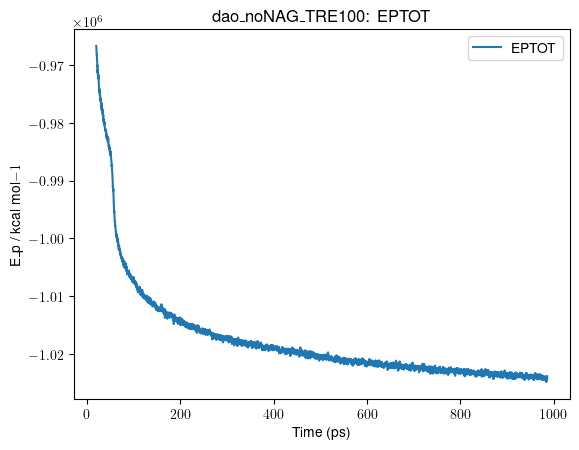

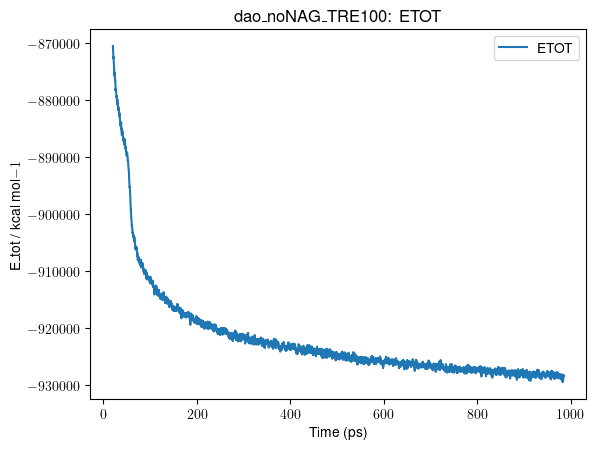

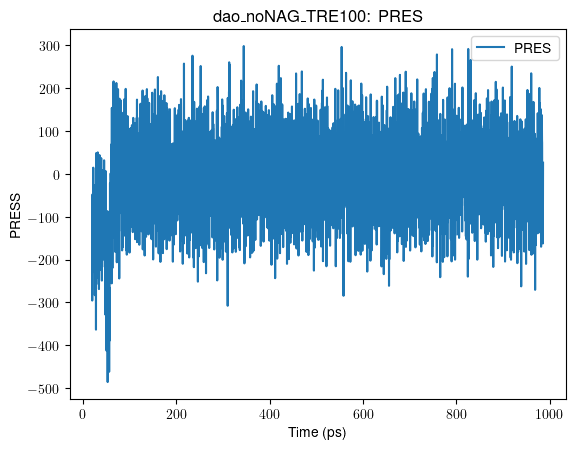

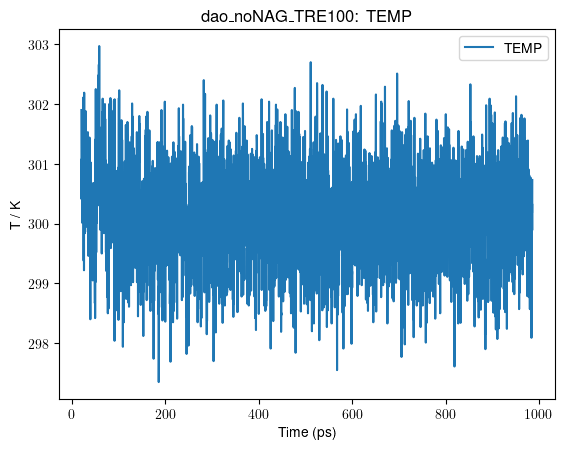

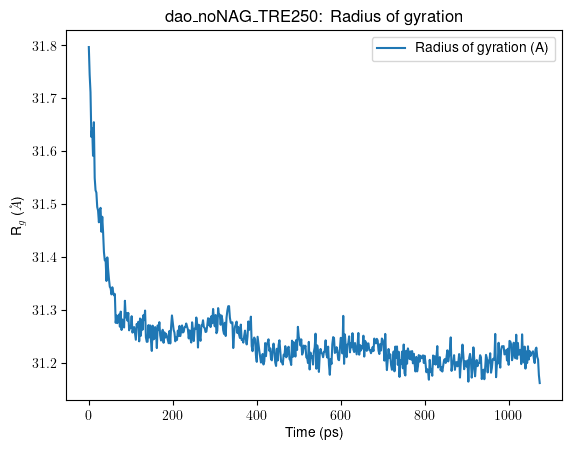

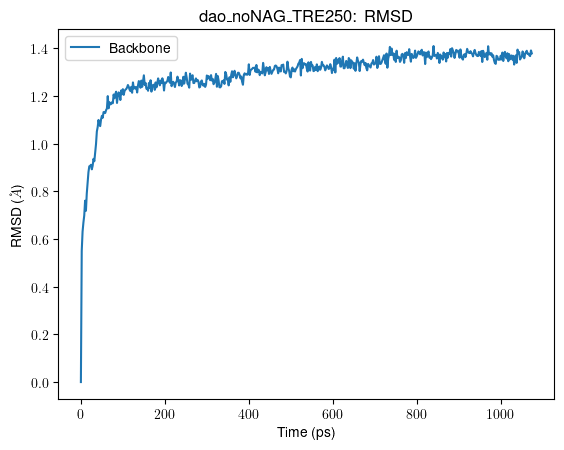

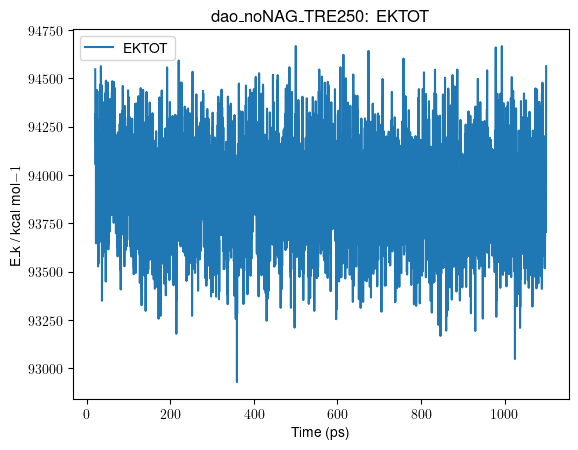

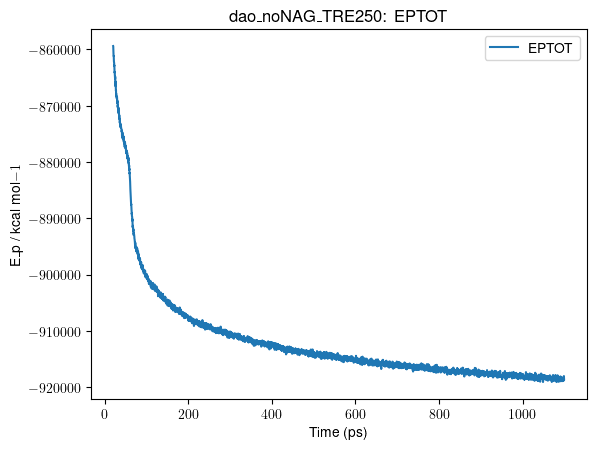

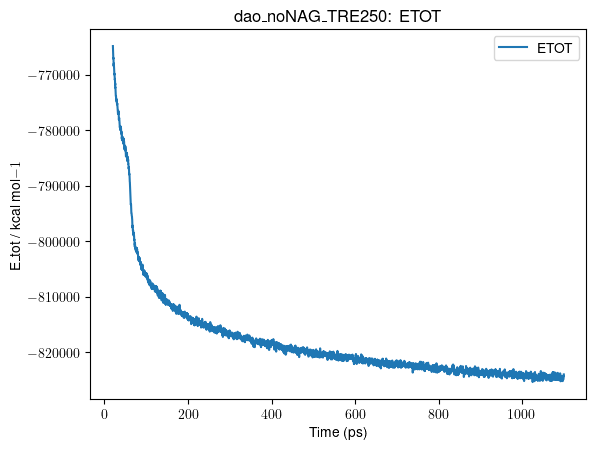

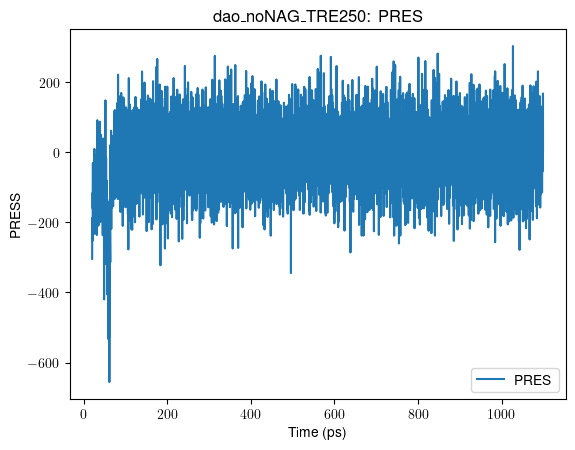

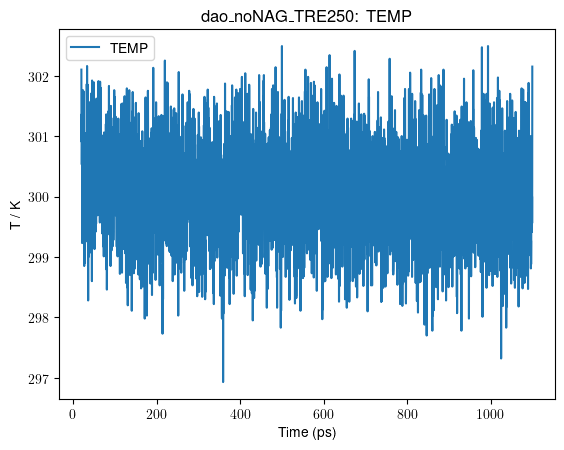

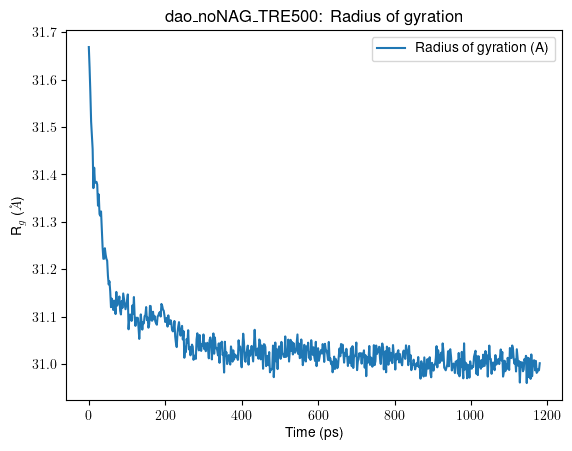

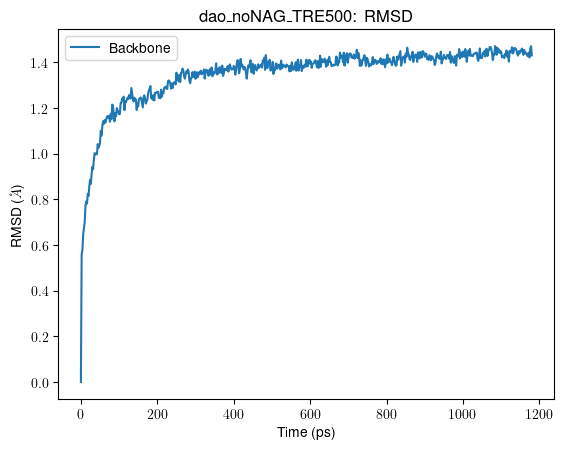

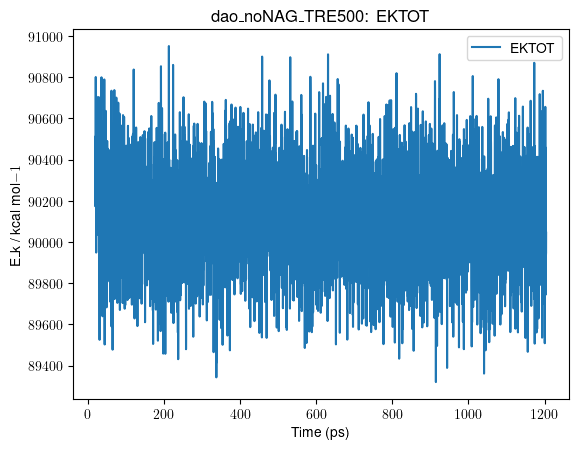

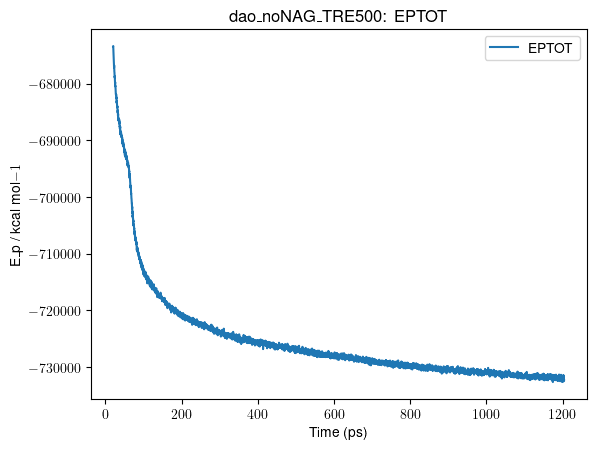

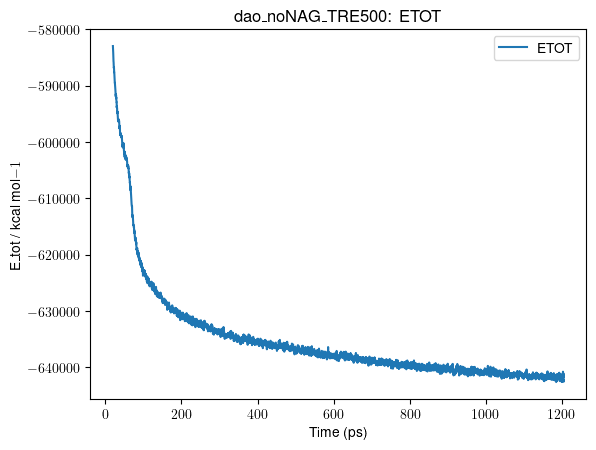

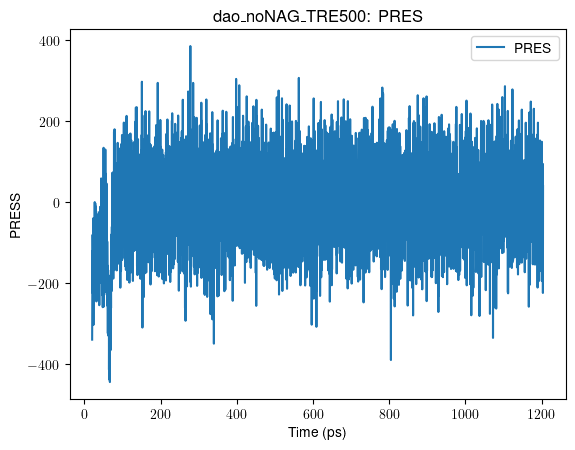

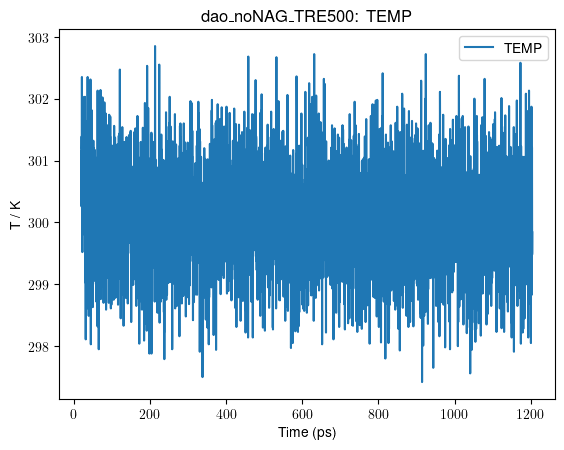

In [4]:
###### Name of the system to be analyzed

#resultsdir = os.environ['SCRATCHDIR']  
backupdir=os.environ['BACKUPFOLDER']
run='md'
dataframedir = './data/'
name,resultsdir='dao_noNAG',backupdir+'/lavandula/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE5',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE25',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE100',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE250',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE500',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)
